In [26]:
# import all necessary packages
import os, sys
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from IPython import display
from pathlib import Path
from tensorflow.keras import layers
import cv2
from sklearn.utils import shuffle
import math

from matplotlib import pyplot as plt
import seaborn as sns

(256, 256, 3)


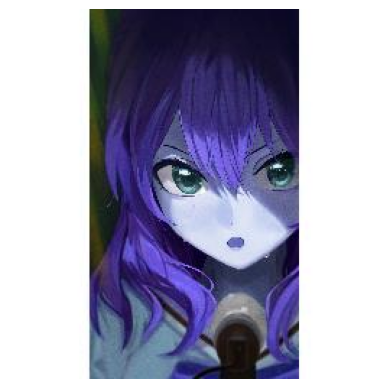

In [27]:
BASE_PATH = "/home/shankar/Documents/datasets/anime_faces/test/train"
BASE_PATH2 = "/home/shankar/Documents/anime_dcgan_project/gelbooru_images/train"
dirs = os.listdir(BASE_PATH2)

from random import randint
def plot_image():
    image = next(get_image_generator())
    image = cv2.imread(image)
    print(image.shape)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def get_image_generator():
    i = randint(0, len(dirs)-1)
    image = f"{BASE_PATH2}/{dirs[i]}"
    yield image

plot_image()

In [28]:
# Function to split the train and test data
def data_split(img_list, train_split=0.8):
    length = len(img_list)
    split = math.floor(length * train_split)
    train_ds = img_list[:split]
    test_ds = img_list[split:]
    return train_ds, test_ds

In [29]:
X_tr = dirs
X_val = os.listdir("/home/shankar/Documents/anime_dcgan_project/gelbooru_images/test")
X_tr_np = []
X_val_np = []
for x in X_tr:
    img = Image.open(f"{BASE_PATH2}/{x}")
    img = np.asarray(img)
    X_tr_np.append(img)
for x in X_val:
    img = Image.open(f"/home/shankar/Documents/anime_dcgan_project/gelbooru_images/test/{x}")
    img = np.asarray(img)
    X_val_np.append(img)
type(X_val_np[0])

numpy.ndarray

In [30]:
BUFFER_SIZE = 2000
BATCH_SIZE = 32
codings_size = 100

In [31]:
generator = keras.Sequential([layers.Dense(7*7*256, use_bias=False, input_shape=[codings_size]),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),

                                 layers.Reshape((7, 7, 256)),
                                 layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 
                                 layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(),
                                 
                                 layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')], name="Generator")

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        51

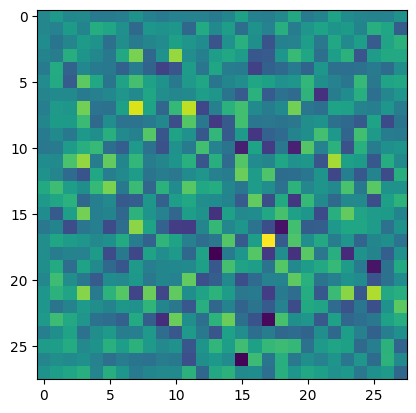

In [32]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
generator.summary()

In [33]:
discriminator = keras.Sequential([layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
                                 layers.LeakyReLU(),
                                 layers.Dropout(0.3),
                                 layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                                 layers.LeakyReLU(),
                                 layers.Dropout(0.3),
                                 
                                 layers.Flatten(),
                                 layers.Dense(1)], name="")

In [34]:
# Split dataset into train and val
DS_PATH = "/home/shankar/Documents/datasets/anime_faces/test"
DS_PATH2 = "/home/shankar/Documents/anime_dcgan_project/gelbooru_images"
train_dst = keras.utils.image_dataset_from_directory(
  DS_PATH2,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(64,64),
  batch_size=BATCH_SIZE)

print(train_dst)

val_dst = keras.utils.image_dataset_from_directory(
  DS_PATH2,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(64,64),
  batch_size=BATCH_SIZE)

val_dst

Found 100 files belonging to 2 classes.
Using 80 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Found 100 files belonging to 2 classes.
Using 20 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
MAIN_PATH = pathlib.Path.cwd()/'gelbooru_images'
#MAIN_PATH = pathlib.Path.cwd()/'..'/'datasets'/'anime_faces'/
train_ds = tf.data.Dataset.list_files(str(MAIN_PATH/"train/*"), shuffle=False)
test_ds = tf.data.Dataset.list_files(str(MAIN_PATH/"test/*"), shuffle=False)

for file in train_ds.take(5):
    print(file.numpy())

b'/home/shankar/Documents/projects/gelbooru_images/train/02ff39dd9152de42f73282cad57afb80.jpeg'
b'/home/shankar/Documents/projects/gelbooru_images/train/0403b7c9111c9dfe4befb96390a216e8.jpg'
b'/home/shankar/Documents/projects/gelbooru_images/train/041b30dbe454852bc8ca71296b5ddbfe.jpg'
b'/home/shankar/Documents/projects/gelbooru_images/train/066c2482de217c58dfc23af2ff159267.jpg'
b'/home/shankar/Documents/projects/gelbooru_images/train/0a170b81ea6024c256b678c87022f5f6.jpg'


In [36]:
print(f'Number of images in the training set: {tf.data.experimental.cardinality(train_ds).numpy()}')
print(f'Number of images in the training set: {tf.data.experimental.cardinality(test_ds).numpy()}')


Number of images in the training set: 88
Number of images in the training set: 12


In [37]:
class_names = np.array(sorted([item.name for item in MAIN_PATH.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['test' 'train']


In [38]:
IMG_SIZE = 64

def load_image(image_path):
    # load image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    
    # get lable value from path
    parts = tf.strings.split(image_path, os.path.sep)    # parse the class label from the file path
    one_hot = parts[-2] == class_names    # select only part with class name and create boolean array
    print(one_hot)
    label = tf.argmax(one_hot)    # get label as integer from boolean array
    
    return (image, label)


In [39]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)

Tensor("Equal:0", shape=(2,), dtype=bool)
Tensor("Equal:0", shape=(2,), dtype=bool)


In [40]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (64, 64, 3)
Label:  1


In [41]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
    
train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

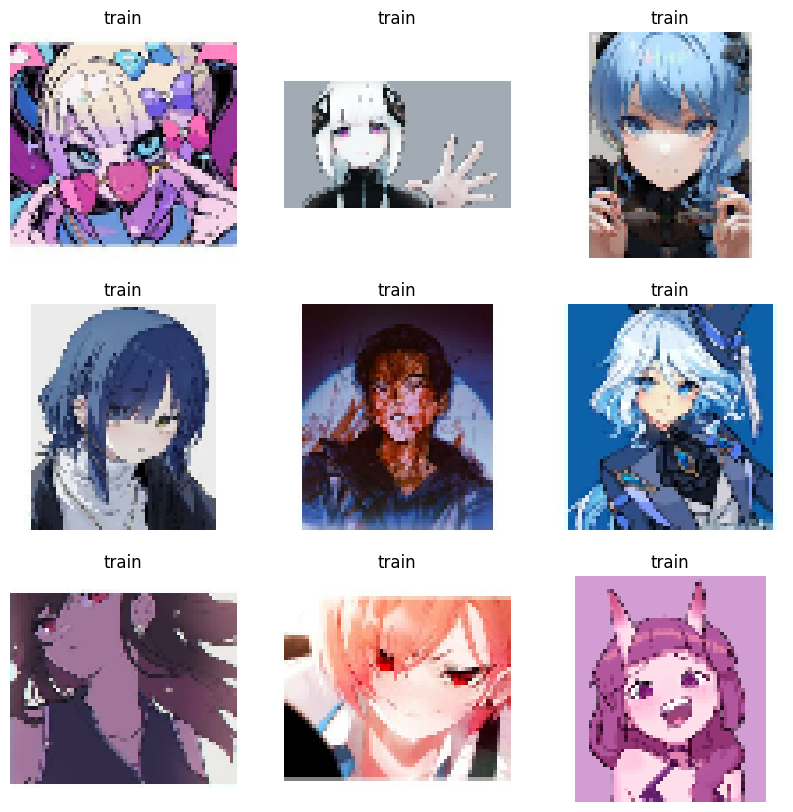

In [52]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("float64")) #use float32 or 64 since it's normalized thus in range [0., 1.], otherwise uint8 since it would be in range [0., 255.]
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

plt.show()

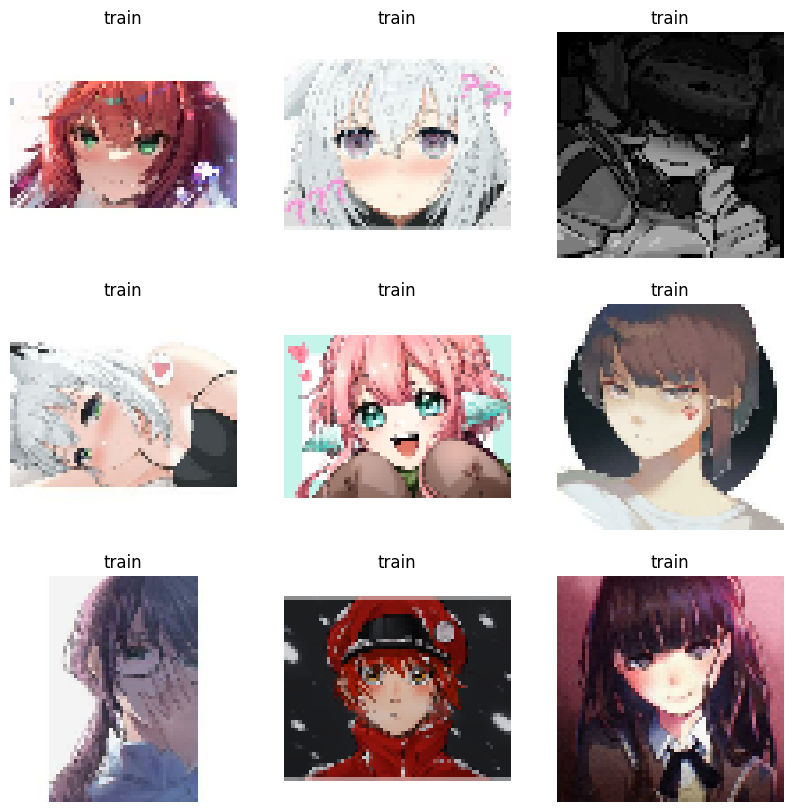

In [43]:
class_names = train_dst.class_names

import matplotlib.pyplot as plt

# Visualize
plt.figure(figsize=(10, 10))
for images, labels in train_dst.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
# Confirm image shapes
for image_batch, labels_batch in train_dst:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [45]:
normalization_layer = keras.layers.Rescaling(1./255)
normalized_ds = train_dst.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(val_dst)

def perf_config(train):
    train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    return train

train_dst = perf_config(normalized_ds)

print(type(val_dst))
val_dst

0.024509806 1.0
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
# Use autoencoder as images are relatively similar
encoder = keras.models.Sequential([
    #layers.Conv2D(16, kernel_size=3, padding="same", activation="selu", input_shape=(64,64,3)),
    #layers.MaxPool2D(pool_size=2),
    #layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    #layers.MaxPool2D(pool_size=2),
    #layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    #layers.MaxPool2D(pool_size=2)
    layers.Flatten(input_shape=(64,64,3)),
    layers.Dense(128, activation="selu"),
    layers.Dense(32, activation="selu")
])
decoder = keras.models.Sequential([
    #layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="selu"),
    #layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
    #layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    layers.Dense(128, activation="selu"),
    layers.Dense(64*64*3, activation="sigmoid")
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss="mean_squared_error", metrics=keras.metrics.binary_accuracy)
history = autoencoder.fit(train_ds, epochs=20, validation_data=val_dst)


Epoch 1/20
3/3 [==============================] - 1s 125ms/step - loss: 0.2465 - binary_accuracy: 0.5417 - val_loss: 0.2344 - val_binary_accuracy: 0.7646
Epoch 2/20
3/3 [==============================] - 0s 58ms/step - loss: 0.0684 - binary_accuracy: 0.9198 - val_loss: 0.1069 - val_binary_accuracy: 0.8930
Epoch 3/20
3/3 [==============================] - 0s 107ms/step - loss: 0.0028 - binary_accuracy: 0.9974 - val_loss: 0.1001 - val_binary_accuracy: 0.8999
Epoch 4/20
3/3 [==============================] - 0s 72ms/step - loss: 2.6986e-05 - binary_accuracy: 1.0000 - val_loss: 0.1000 - val_binary_accuracy: 0.9000
Epoch 5/20
3/3 [==============================] - 0s 120ms/step - loss: 4.8786e-07 - binary_accuracy: 1.0000 - val_loss: 0.1000 - val_binary_accuracy: 0.9000
Epoch 6/20
3/3 [==============================] - 0s 72ms/step - loss: 4.4867e-09 - binary_accuracy: 1.0000 - val_loss: 0.1000 - val_binary_accuracy: 0.9000
Epoch 7/20
3/3 [==============================] - 0s 91ms/step - lo

In [68]:
keras.utils.plot_model(
    autoencoder,
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


1/1 [==============================] - 0s 81ms/step
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1.

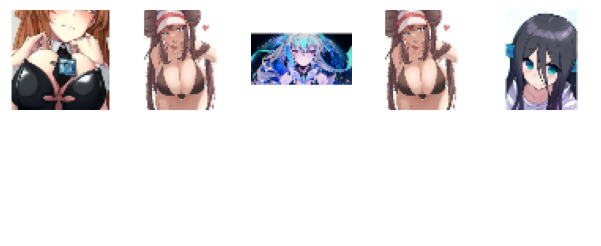

In [56]:
def plot_image(image):
    plt.imshow(image.numpy().astype("uint8"), cmap="jet")
    plt.axis("off")

def show_reconstructions(model, images=val_dst, n_images=5):
    #print(images)
    #images = images.unbatch()
    #print(images)
    #images = list(images.map(lambda x, y: x))
    for i,j in images:
        #print(i[0].shape)
        img = i
        reconstructions = model.predict(i[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        for i, j in images:
            plt.subplot(2, n_images, 1 + image_index)
            plt.imshow(i[image_index].numpy().astype("uint8"), cmap="jet")
            plt.axis("off")

            plt.subplot(2, n_images, 1 + n_images + image_index)
            print(reconstructions[image_index].reshape((64,64,3)))
            r = reconstructions[image_index].reshape((64,64,3))
            plt.imshow(r.astype("float64"), cmap="gray")
            plt.axis("off")

show_reconstructions(autoencoder)

In [59]:
gan = keras.models.Sequential([generator, discriminator])
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable=False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [49]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")  


In [60]:
test_random_vector = tf.random.normal(shape=[32, 10])

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=2):
    
    generator, discriminator = gan.layers
    itr=0
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs)) 
        for X_batch in dataset:
            # Phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            
            # feed `test_random_vector` to Generator each 100th iteration
            # and plot generated images
            if (itr%100 == 0):  
                gen_images = generator.predict(test_random_vector)
                plot_multiple_images(gen_images, 8)
                plt.show()
                         
            itr+=1

In [61]:
train_gan(gan, train_ds, BATCH_SIZE, 10, n_epochs=2)

Epoch 1/2


ValueError: Input 0 of layer "Generator" is incompatible with the layer: expected shape=(None, 100), found shape=(32, 10)